In [1]:
import numpy as np
import pandas as pd
import time
import heapq
import copy
import matplotlib.pyplot as plt

Understanding the distributions

In [2]:
df = pd.read_excel("data.xls")

In [3]:
arrivalTimingsSec = df["Arrival time (sec)"].values
baseStations = df["Base station "].values
callDurationsSec = df["Call duration (sec)"].to_numpy()
velocitiesKmHr = df["velocity (km/h)"].to_numpy()

Converting data to required units

In [4]:
# Inter-arrival Seconds to milliseconds
interArrivalTimingsSec = np.diff(arrivalTimingsSec)
interArrivalTimingsMs = interArrivalTimingsSec * 1000.0

# Call duration Seconds to milliseconds
callDurationsMs = callDurationsSec * 1000.0

# Velocity km/hr to cm/ms
velocitiesCmHr = velocitiesKmHr * 1000.0 * 100.0
velocitiesCmMs = velocitiesCmHr / 60.0 / 60.0 / 1000.0

Creating Distribution

In [5]:
rndGenerator = np.random.default_rng()
initiationTime_mean = interArrivalTimingsMs.mean()
callDurationsMs_mean = callDurationsMs.mean()
velocity_mean, velocity_std = velocitiesCmMs.mean(), velocitiesCmMs.std()

def genInitiationTime():
    return rndGenerator.exponential(initiationTime_mean)

def genCallDuration():
    return rndGenerator.exponential(callDurationsMs_mean)

def genCarVelocity():
    return rndGenerator.normal(velocity_mean, velocity_std)

def genCarPosition():
    return rndGenerator.integers(200001)

def genBaseStation():
    return rndGenerator.integers(20)

def genCarDirection():
    return rndGenerator.integers(2)

print("inter-arrival:", genInitiationTime())
print("call duration:", genCallDuration())
print("car velocity:", genCarVelocity())
print("car position:", genCarPosition())
print("base station:", genBaseStation())
print("car direction:", genCarDirection())

inter-arrival: 2107.688534721333
call duration: 176572.9954086494
car velocity: 3.041356874721947
car position: 87205
base station: 14
car direction: 1


System Variables required to run the model

State Variables to represent the Model

Simulation Variables

Class for all the data

In [6]:
class SimulationData:
    def __init__(self, numOfChannels, resHandoverCh, simulationLength, warmupPeriod) -> None:
        self.setNumOfChannels(numOfChannels)
        self.setResHandoverCh(resHandoverCh)
        self.setSimulationLength(simulationLength)
        self.setWarmupPeriod(warmupPeriod)
        self.systemData = SystemData()
        self.stateData = StateData(self)

    def setNumOfChannels(self, numOfChannels):
        self.__numOfChannels = numOfChannels # Number of channels in a base station
        self.numOfChannels = self.__numOfChannels
    
    def setResHandoverCh(self, resHandoverCh):
        self.__resHandoverCh = resHandoverCh # Number of reserved handover channels
        self.resHandoverCh = self.__resHandoverCh

    def setSimulationLength(self, simulationLength):
        self.__simulationLength = simulationLength # 9223372036854775807
        self.simulationLength = self.__simulationLength

    def setWarmupPeriod(self, warmupPeriod):
        self.__warmupPeriod = warmupPeriod # Out of 100 percent
        self.warmupPeriod = self.__warmupPeriod

    def reset(self):
        self.numOfChannels = self.__numOfChannels
        self.resHandoverCh = self.__resHandoverCh
        self.simulationLength = self.__simulationLength
        self.warmupPeriod = self.__warmupPeriod
        self.systemData.reset()
        self.stateData.reset()

class SystemData:
    def __init__(self) -> None:
        self.startClock = time.time()
        self.endClock = time.time()
        self.simClock = 0
        self.FEL = []
        self.warmupEnd = False

    def pushEvent(self, time, event):
        heapq.heappush(self.FEL, (time, event))
    
    def popEvent(self):
        return heapq.heappop(self.FEL)

    def reset(self):
        self.startClock = time.time()
        self.endClock = time.time()
        self.simClock = 0
        self.FEL = []
        self.warmupEnd = False

class StateData:
    def __init__(self, simData) -> None:
        self.simData = simData
        self.baseStations = [simData.numOfChannels]*20

    def reset(self):
        self.baseStations = [self.simData.numOfChannels]*20

Statistical Counters

In [7]:
class StatisticRecorder:
    def __init__(self, simData:SimulationData) -> None:
        self.simData = simData
        self.bCalls = 0
        self.dCalls = 0
        self.tCalls = 0
        self.cCalls = 0
        self.history = []
        self.__historyList = []
        self.records = []

    def reset(self):
        self.bCalls = 0
        self.dCalls = 0
        self.tCalls = 0
        self.cCalls = 0

    def add(self, b, d, t, c, log):
        if log:
            self.bCalls += b
            self.dCalls += d
            self.tCalls += t
            self.cCalls += c

    def createRecord(self):
        tempBaseStations = []
        for i in range(20):
            tempBaseStations.append("station"+str(i))
        self.history.append(pd.DataFrame(data=self.__historyList, 
                                         columns=['Event', 'Call', 'realTimeClock', 'simClock',
                                                'warmup', 'reserved',
                                                'blocked','dropped','completed','total',
                                                'currentCalls','blockPerc','dropPerc']
                                                +tempBaseStations))
        self.__historyList.clear()

    def createSubRecord(self, event, call:str):
        self.__historyList.append([type(event), call, 
                                float(self.simData.systemData.endClock - self.simData.systemData.startClock),
                                self.simData.systemData.simClock,
                                self.simData.warmupPeriod, self.simData.resHandoverCh,
                                self.bCalls, self.dCalls, self.cCalls, self.tCalls,
                                len(self.simData.systemData.FEL)-1,
                                self.bCalls/self.tCalls*100 if self.tCalls > 0 else 0, 
                                self.dCalls/self.tCalls*100 if self.tCalls > 0 else 0] +
                                self.simData.stateData.baseStations
                                )

    def clear(self):
        self.history.clear()
        self.__historyList.clear()
        self.reset()

Objects

In [8]:
class Call:
    def __init__(self) -> None:
        self.start = None
        self.end = None
        self.interDur = None
        self.duration = None
        self.velocity = None
        self.position = None
        self.baseStation = None
        self.direction = None
        self.constantHandover = 1

Events

In [9]:
class Event:
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        self.simData = simData
        self.statsRecorder = statsRecorder
        self.call = call
        self.item = item + 1
        if self.call.start is not None:
            self.call.end = self.item
        else:
            self.call.start = self.item
        self.log = log

    def __lt__(self, other):
        return self.item < other.item

    def run(self):
        pass

class CallTerminationEvent(Event):
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        super().__init__(simData, statsRecorder, call, log, item)

    def run(self):
        self.simData.stateData.baseStations[self.call.baseStation] += 1
        self.statsRecorder.add(0,0,0,1,self.log)

class CallHandoverEvent(Event):
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        super().__init__(simData, statsRecorder, call, log, item)

    def run(self):
        # Release channel usage in current Base Station
        self.simData.stateData.baseStations[self.call.baseStation] += 1
        # Determine next Base Station
        if self.call.direction == 0: # Left
            self.call.baseStation -= 1
        else: # Right
            self.call.baseStation += 1

        # Base Station out of bound [1,20]
        if self.call.baseStation < 0 or self.call.baseStation >= 20:
            self.statsRecorder.add(0,0,0,1,self.log)
            return
        
        # Base Station not out of bound & No free channels
        if self.simData.stateData.baseStations[self.call.baseStation] <= 0:
            self.statsRecorder.add(0,1,0,1,self.log)
        else:
            # Set call to occupy free channel
            self.simData.stateData.baseStations[self.call.baseStation] -= 1
            # Compare Call Duration and Handover
            if self.call.duration > self.call.constantHandover:
                event = CallHandoverEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + self.call.constantHandover, event)
                self.call.duration -= self.call.constantHandover
            else:
                event = CallTerminationEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + self.call.duration, event)


class CallInitiationEvent(Event):
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        super().__init__(simData, statsRecorder, call, log, item)

    def run(self):
        # Schedule next call initiation event
        call = Call()
        callInitTime = genInitiationTime()
        nextCallTime = self.simData.systemData.simClock + callInitTime
        call.interDur = callInitTime
        event = CallInitiationEvent(self.simData, self.statsRecorder, call, self.simData.systemData.warmupEnd, self.item)
        self.simData.systemData.pushEvent(nextCallTime, event)

        # Begin Begin Call Initiation
        # Initialize basic call Attributes
        self.call.baseStation = genBaseStation()

        # Statistic Counter
        self.statsRecorder.add(0,0,1,0,self.log)

        # No free channels
        if self.simData.stateData.baseStations[self.call.baseStation] <= self.simData.resHandoverCh: # No free channels
            self.statsRecorder.add(1,0,0,1,self.log)
            return
        else: # Have free channels
            # Set call to occupy free channel
            self.simData.stateData.baseStations[self.call.baseStation] -= 1
            # Set up call
            self.call.position = genCarPosition()
            self.call.velocity = genCarVelocity()
            self.call.duration = genCallDuration()
            self.call.direction = genCarDirection()
            # Calculate Initial Handover Time
            timeToHandover = None
            if self.call.direction == 0: # Left
                timeToHandover = self.call.position/self.call.velocity
            else:
                timeToHandover = (200000 - self.call.position)/self.call.velocity
            # Calculate Constant Handover Time
            self.call.constantHandover = 200000/self.call.velocity
            # Compare Call Duration and Handover
            if self.call.duration > timeToHandover:
                event = CallHandoverEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + timeToHandover, event)
                self.call.duration -= timeToHandover
            else:
                event = CallTerminationEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + self.call.duration, event)

Main Program

In [58]:
class Simulation:
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder) -> None:
        self.simData = simData
        self.statsRecorder = statsRecorder

    def simulate(self):
        self.reset()
        startTime = time.time()
        self.simData.systemData.startClock = startTime
        callInitTime = genInitiationTime()
        call = Call()
        call.interDur = callInitTime
        event = CallInitiationEvent(self.simData, self.statsRecorder, call, False, 0)
        if self.simData.warmupPeriod < callInitTime: # Warmup over
            event.log = True
        self.simData.systemData.pushEvent(event.call.interDur, event)
        while (self.simData.systemData.simClock <= self.simData.warmupPeriod):
            FELObject = self.simData.systemData.popEvent()
            event = FELObject[1]
            self.simData.systemData.simClock = FELObject[0]
            event.run()
            self.statsRecorder.createSubRecord(event, str(event.call.start) + "-" + str(event.call.end))
        self.simData.systemData.warmupEnd = True
        while (self.simData.systemData.simClock <= self.simData.simulationLength):
            FELObject = self.simData.systemData.popEvent()
            event = FELObject[1]
            self.simData.systemData.simClock = FELObject[0]
            event.run()
            self.statsRecorder.createSubRecord(event, str(event.call.start) + "-" + str(event.call.end))
            self.simData.systemData.endClock = time.time()
        self.genStatisticReport()

    def reset(self):
        self.simData.reset()
           
    def genStatisticReport(self):
        self.statsRecorder.createRecord()
        self.statsRecorder.reset()
    
    def clearStats(self):
        self.statsRecorder.clear()

    def displayStats(self):
        numberOfStats = len(self.statsRecorder.history)
        qosBlocked = 0
        qosDropped = 0
        for stats in self.statsRecorder.history:
            qosBlocked += stats['blockPerc'].iloc[-1]
            qosDropped += stats['dropPerc'].iloc[-1]
        print("Number of runs:", numberOfStats)
        print("Average qos for blocked:", qosBlocked/numberOfStats, "%")
        print("Average qos for dropped:", qosDropped/numberOfStats, "%")

Verifying if the simulation runs as expected

In [11]:
testSimData = SimulationData(3, 0, 100000, 0)
testStatsRecorder = StatisticRecorder(testSimData)
testSim = Simulation(testSimData, testStatsRecorder)

testSim.simulate()

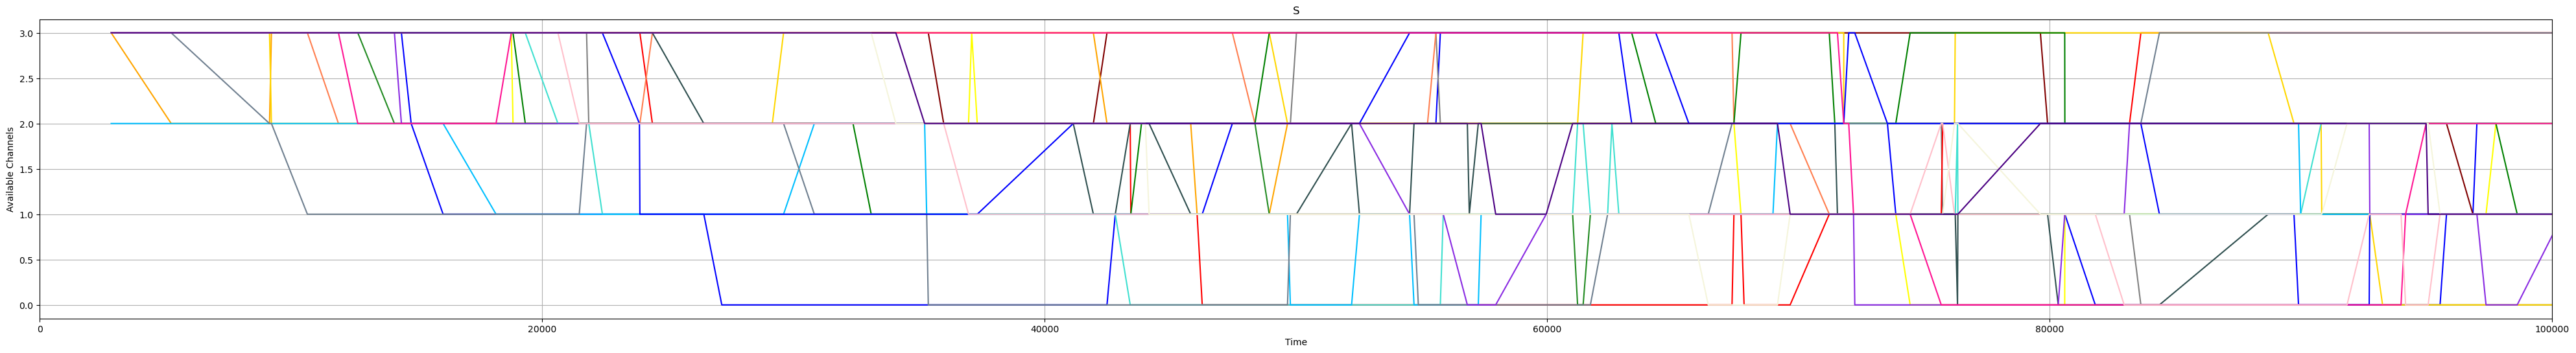

In [12]:
# Plot line graph
plt.close()
plt.figure(figsize=(50, 6))
cycol = ["b","gray","red","coral","maroon","orange","gold","yellow","green","forestgreen","turquoise","darkslategray","deepskyblue","slategray","blue","blueviolet","deeppink","pink","beige","indigo"]
for i in range(20):
    t = "station" + str(i)
    plt.plot(testStatsRecorder.history[0]["simClock"], testStatsRecorder.history[0][t], color=cycol[i])
plt.xlabel('Time')
plt.ylabel('Available Channels')
plt.title('S')
plt.grid(True)
plt.xlim(0, 100000)
plt.show()

In [13]:
testStatsRecorder.history[0].to_csv('test_result.csv')

The simulation runs as expected. Prepping future simulations.

Finding best warmup period

In [14]:
warmupSimData = SimulationData(10, 0, 5000000, 0)
warmupStatsRecorder = StatisticRecorder(warmupSimData)
warmupSim = Simulation(warmupSimData, warmupStatsRecorder)

Run simulation 50 times and find the average number of calls.

In [15]:
warmupSim.clearStats()
for i in range(50):
    warmupSim.simulate()

In [16]:
np.array([hist['currentCalls'].mean() for hist in warmupStatsRecorder.history]).mean()

71.68558462304813

In [17]:
sumOfSimClock = 0
for hist in warmupStatsRecorder.history:
    for val in hist['simClock'].loc[hist['currentCalls'] > 71]:
        sumOfSimClock += val
        break
avgOfSimClock = sumOfSimClock/len(warmupStatsRecorder.history)
print(avgOfSimClock)

263301.7186672877


We found that the average simClock to begin seeing the average currentCalls is around 255896.

Hence, we'll take a look at the graph for a better visualization of the warmup time

In [18]:
warmupStatsRecorder.history[0]["simClock"].loc[warmupStatsRecorder.history[0]["simClock"] < 255896]

0        2042.550164
1        2154.121273
2        3106.051174
3        3458.533553
4        5316.110860
           ...      
471    253915.801775
472    254518.135956
473    254588.846377
474    254948.540283
475    255063.560884
Name: simClock, Length: 476, dtype: float64

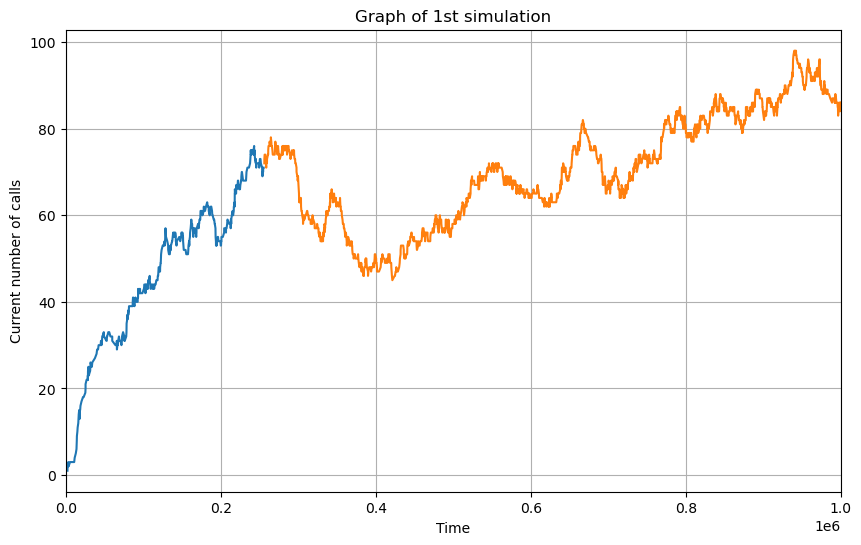

In [19]:
# Plot line graph
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(warmupStatsRecorder.history[0]["simClock"].loc[warmupStatsRecorder.history[0]["simClock"] < 255896], warmupStatsRecorder.history[0]["currentCalls"].loc[warmupStatsRecorder.history[0]["simClock"] < 255896])
plt.plot(warmupStatsRecorder.history[0]["simClock"].loc[warmupStatsRecorder.history[0]["simClock"] >= 255896], warmupStatsRecorder.history[0]["currentCalls"].loc[warmupStatsRecorder.history[0]["simClock"] >= 255896])
plt.xlabel('Time')
plt.ylabel('Current number of calls')
plt.title('Graph of 1st simulation')
plt.grid(True)
plt.xlim(0, 1000000)
plt.show()

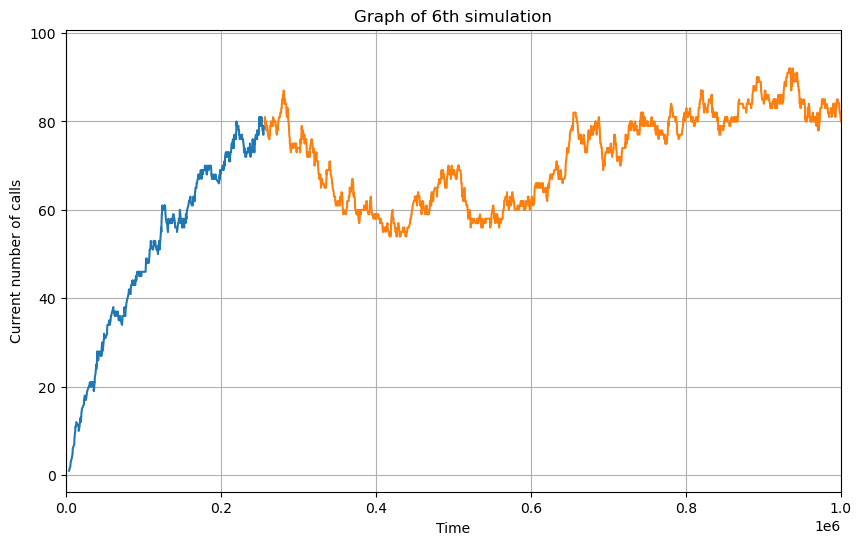

In [20]:
# Plot line graph
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(warmupStatsRecorder.history[5]["simClock"].loc[warmupStatsRecorder.history[5]["simClock"] < 255896], warmupStatsRecorder.history[5]["currentCalls"].loc[warmupStatsRecorder.history[5]["simClock"] < 255896])
plt.plot(warmupStatsRecorder.history[5]["simClock"].loc[warmupStatsRecorder.history[5]["simClock"] >= 255896], warmupStatsRecorder.history[5]["currentCalls"].loc[warmupStatsRecorder.history[5]["simClock"] >= 255896])
plt.xlabel('Time')
plt.ylabel('Current number of calls')
plt.title('Graph of 6th simulation')
plt.grid(True)
plt.xlim(0, 1000000)
plt.show()

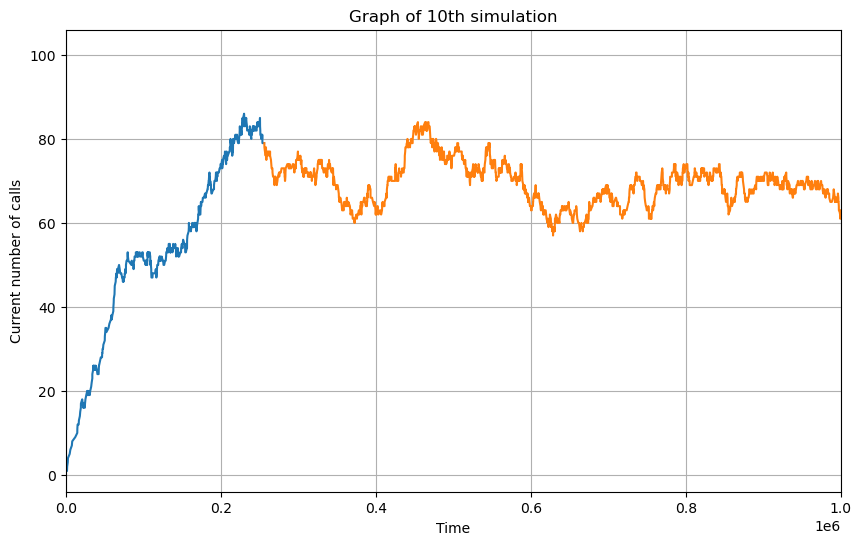

In [21]:
# Plot line graph
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(warmupStatsRecorder.history[10]["simClock"].loc[warmupStatsRecorder.history[10]["simClock"] < 255896], warmupStatsRecorder.history[10]["currentCalls"].loc[warmupStatsRecorder.history[10]["simClock"] < 255896])
plt.plot(warmupStatsRecorder.history[10]["simClock"].loc[warmupStatsRecorder.history[10]["simClock"] >= 255896], warmupStatsRecorder.history[10]["currentCalls"].loc[warmupStatsRecorder.history[10]["simClock"] >= 255896])
plt.xlabel('Time')
plt.ylabel('Current number of calls')
plt.title('Graph of 10th simulation')
plt.grid(True)
plt.xlim(0, 1000000)
plt.show()

Finding the best simulation length

In [46]:
# bestSimLengthSimData = SimulationData(10, 0, 1000000, 255896)
# bestSimLengthStatsRecorder = StatisticRecorder(bestSimLengthSimData)
# bestSimLengthSim = Simulation(bestSimLengthSimData, bestSimLengthStatsRecorder)
# for i in range(10):
#     bestSimLengthSimData.setSimulationLength(6000000 + i * 500000)
#     for j in range(50):
#         bestSimLengthSim.simulate()
#     bestSimLengthSim.displayStats()
#     bestSimLengthSim.clearStats()

Number of runs: 50
Average qos for blocked: 0.3207497299088527
Average qos for dropped: 0.5167476653122409
Number of runs: 50
Average qos for blocked: 0.3218070777931068
Average qos for dropped: 0.524584404463593
Number of runs: 50
Average qos for blocked: 0.32742759423876094
Average qos for dropped: 0.5731588866547161
Number of runs: 50
Average qos for blocked: 0.3367372782222117
Average qos for dropped: 0.5491104997866821
Number of runs: 50
Average qos for blocked: 0.34373002723717705
Average qos for dropped: 0.5494363336706329
Number of runs: 50
Average qos for blocked: 0.32476777153895825
Average qos for dropped: 0.5569977280678962
Number of runs: 50
Average qos for blocked: 0.320582568922441
Average qos for dropped: 0.5592974146108346
Number of runs: 50
Average qos for blocked: 0.3531019198146354
Average qos for dropped: 0.6208408091427576
Number of runs: 50
Average qos for blocked: 0.3201734233203306
Average qos for dropped: 0.5597150227379379
Number of runs: 50
Average qos for b

From 1,000,000 to 5,500,000

Number of runs: 50
Average qos for blocked: 0.3060691384445759
Average qos for dropped: 0.47718270090239023

Number of runs: 50
Average qos for blocked: 0.28394661814586014
Average qos for dropped: 0.4629762547835092

Number of runs: 50
Average qos for blocked: 0.337986093703509
Average qos for dropped: 0.480910932582395

Number of runs: 50
Average qos for blocked: 0.29869761652679666
Average qos for dropped: 0.48386713276755855

Number of runs: 50
Average qos for blocked: 0.32139999733282926
Average qos for dropped: 0.5582896608635043

Number of runs: 50
Average qos for blocked: 0.33977964057517096
Average qos for dropped: 0.5458545475616953

Number of runs: 50
Average qos for blocked: 0.3355555604050276
Average qos for dropped: 0.5328772459999385

Number of runs: 50
Average qos for blocked: 0.329567935464647
Average qos for dropped: 0.5522907570621406

Number of runs: 50
Average qos for blocked: 0.28497130813272614
Average qos for dropped: 0.5097825995998142

Number of runs: 50
Average qos for blocked: 0.32505190227714764
Average qos for dropped: 0.5530327714867593

From 6,000,000 to 15,000,000

Number of runs: 50
Average qos for blocked: 0.3207497299088527
Average qos for dropped: 0.5167476653122409

Number of runs: 50
Average qos for blocked: 0.3218070777931068
Average qos for dropped: 0.524584404463593

Number of runs: 50
Average qos for blocked: 0.32742759423876094
Average qos for dropped: 0.5731588866547161

Number of runs: 50
Average qos for blocked: 0.3367372782222117
Average qos for dropped: 0.5491104997866821

Number of runs: 50
Average qos for blocked: 0.34373002723717705
Average qos for dropped: 0.5494363336706329

Number of runs: 50
Average qos for blocked: 0.32476777153895825
Average qos for dropped: 0.5569977280678962

Number of runs: 50
Average qos for blocked: 0.320582568922441
Average qos for dropped: 0.5592974146108346

Number of runs: 50
Average qos for blocked: 0.3531019198146354
Average qos for dropped: 0.6208408091427576

Number of runs: 50
Average qos for blocked: 0.3201734233203306
Average qos for dropped: 0.5597150227379379

Number of runs: 50
Average qos for blocked: 0.30892457756247393
Average qos for dropped: 0.5465635210938513

Running simulation for No Channel Reservation

In [54]:
simData = SimulationData(10, 0, 3500000, 255896)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)
for i in range(50):
    sim.simulate()
sim.displayStats()

Number of runs: 50
Average qos for blocked: 0.32667854829945786
Average qos for dropped: 0.5156196752167062


Running simulation for 1 Channel Reservation

In [50]:
simData = SimulationData(10, 1, 3500000, 255896)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)
for i in range(50):
    sim.simulate()
sim.displayStats()

Number of runs: 50
Average qos for blocked: 0.973181581291324
Average qos for dropped: 0.3250130017185533


In [51]:
simData = SimulationData(10, 2, 3500000, 255896)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)
for i in range(50):
    sim.simulate()
sim.displayStats()

Number of runs: 50
Average qos for blocked: 2.6623674826598984
Average qos for dropped: 0.19548578848765366


In [55]:
simData = SimulationData(10, 3, 3500000, 255896)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)
for i in range(50):
    sim.simulate()
sim.displayStats()

Number of runs: 50
Average qos for blocked: 5.314302426140525
Average qos for dropped: 0.07900513479305618


In [52]:
simData = SimulationData(10, 4, 3500000, 255896)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)
for i in range(50):
    sim.simulate()
sim.displayStats()

Number of runs: 50
Average qos for blocked: 10.253276975609776
Average qos for dropped: 0.02525786061933796


In [57]:
simData = SimulationData(10, 7, 3500000, 255896)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)
for i in range(50):
    sim.simulate()
sim.displayStats()

Number of runs: 50
Average qos for blocked: 39.55676093622477
Average qos for dropped: 0.0
